📊 Loading processed data...
✅ Loaded 10000 Amazon reviews
Columns: ['Id', 'ProductId', 'UserId', 'ProfileName', 'HelpfulnessNumerator', 'HelpfulnessDenominator', 'Score', 'Time', 'Summary', 'Text', 'sentiment', 'sentiment_label', 'binary_sentiment', 'processed_text', 'combined_text', 'processed_combined', 'text_length', 'word_count', 'processed_word_count']

📈 Data splits:
Training: 6400 samples
Validation: 1600 samples
Test: 2000 samples

Class distribution (train): [1526 4874]
Class balance: 76.16% positive

🚀 Training SVM Variants...

1️⃣ Linear SVM
Validation Accuracy: 0.8319
Training Time: 0.53 seconds

2️⃣ RBF Kernel SVM (on subset for speed)
Validation Accuracy: 0.8375
Training Time: 17.57 seconds

3️⃣ SGD-based SVM (Fast)
Validation Accuracy: 0.8356
Training Time: 0.52 seconds

🔧 Hyperparameter Tuning for Linear SVM...
Running grid search... (this may take a few minutes)
Fitting 3 folds for each of 16 candidates, totalling 48 fits

✅ Best parameters: {'classifier__C': 1.0, 'tfi

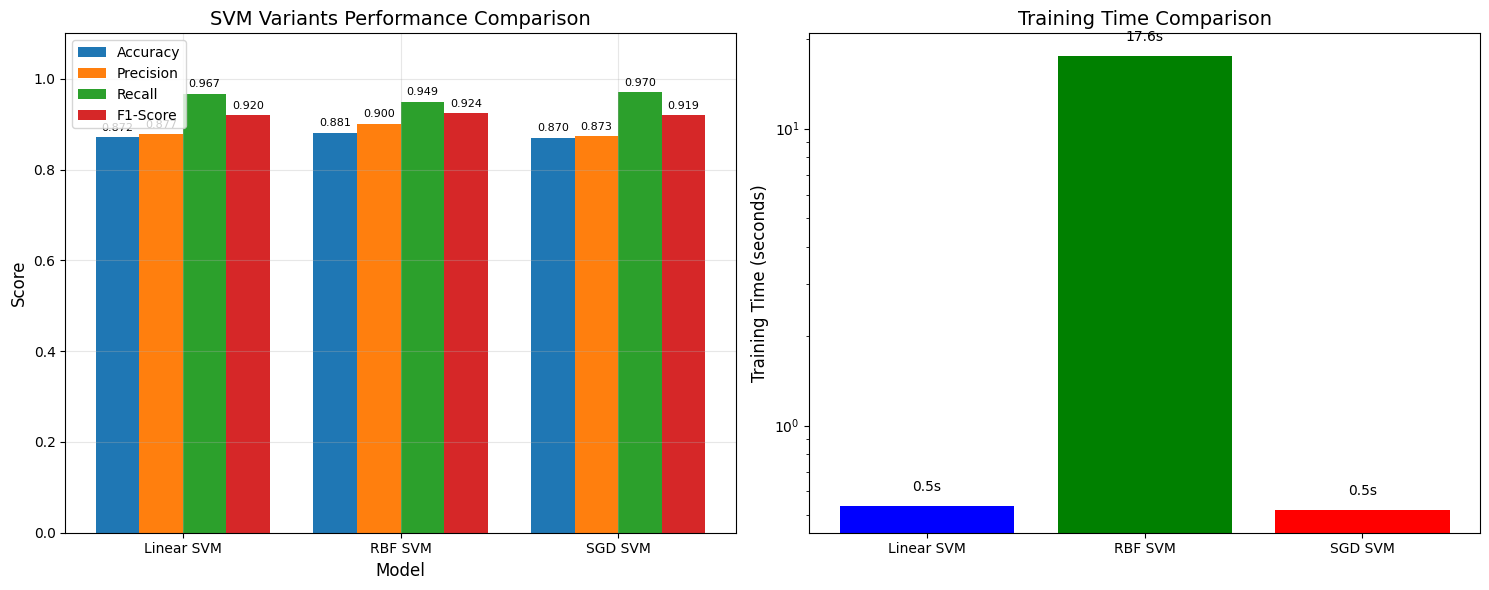


🎯 Detailed Evaluation of Best Tuned Model...

Best Model Test Performance:
Accuracy:  0.8730
Precision: 0.8793
Recall:    0.9659
F1-Score:  0.9205
ROC AUC:   0.9120

📋 Classification Report:
              precision    recall  f1-score   support

    Negative       0.84      0.58      0.68       477
    Positive       0.88      0.97      0.92      1523

    accuracy                           0.87      2000
   macro avg       0.86      0.77      0.80      2000
weighted avg       0.87      0.87      0.86      2000



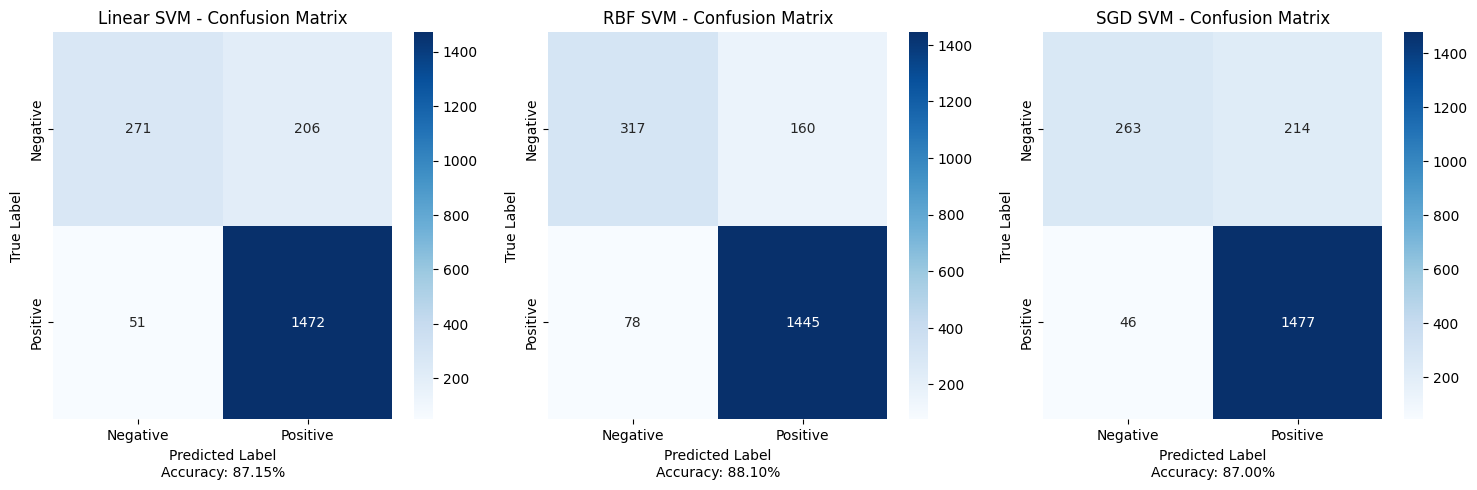

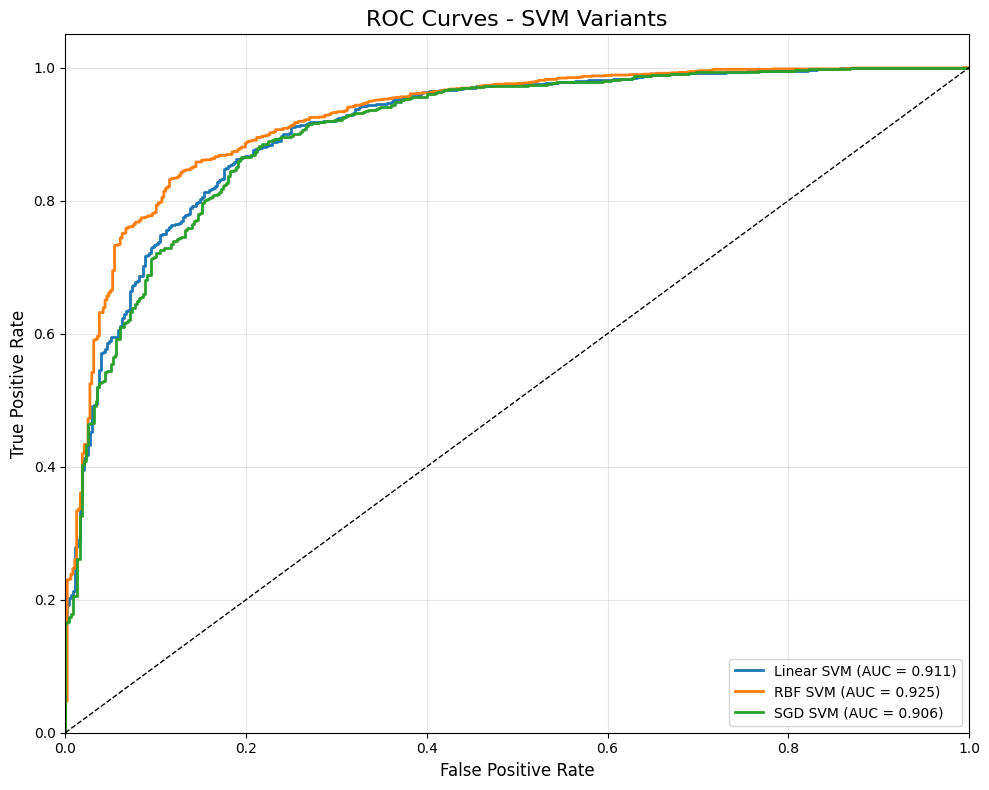


📊 Support Vector Analysis...
RBF SVM Support Vectors:
  Total support vectors: 3899
  Support vectors per class: [1113 2786]
  Percentage of training data: 78.0%


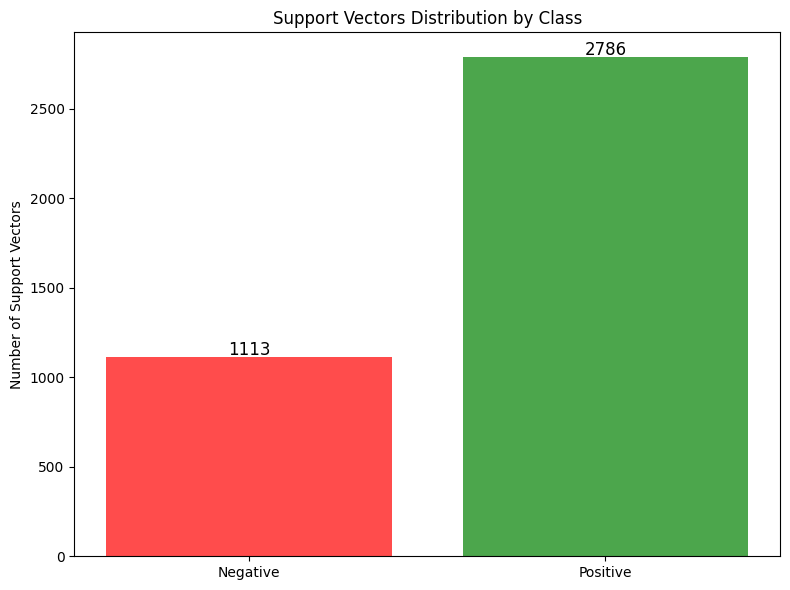


🎨 Decision Boundary Visualization (2D projection)...


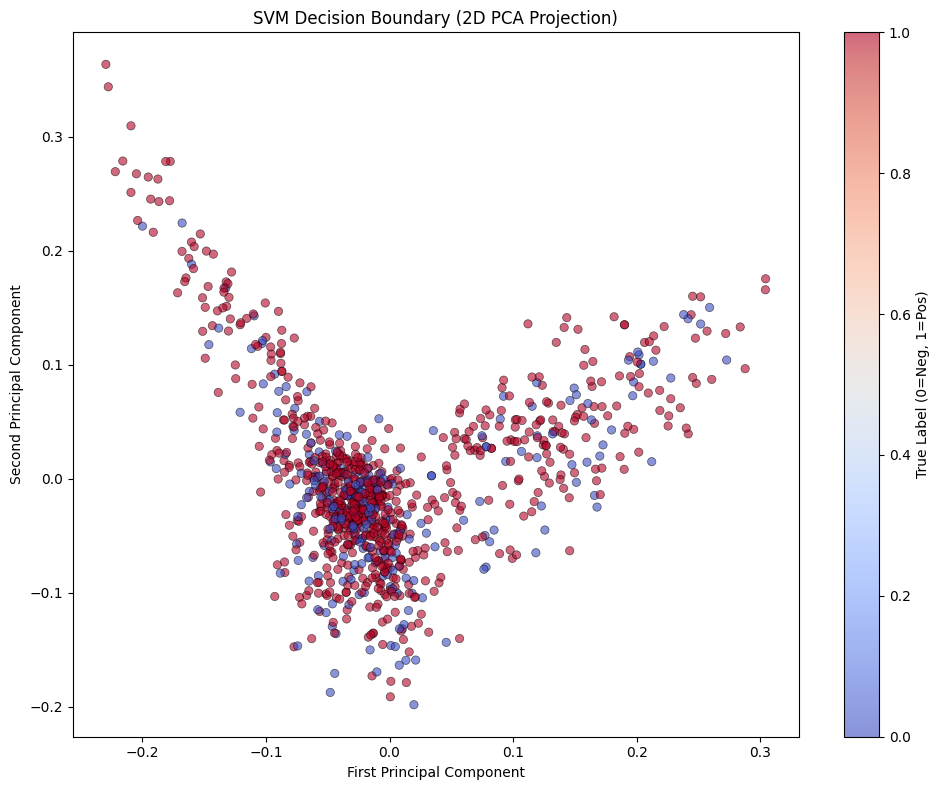


🔄 Cross-Validation Results:

Linear SVM:
  F1 scores: [0.9035 0.909  0.9147 0.9038 0.9051]
  Mean F1: 0.9072 (+/- 0.0084)

RBF SVM:
  F1 scores: [0.906  0.9173 0.9235 0.9122 0.9088]
  Mean F1: 0.9136 (+/- 0.0125)

💾 Saving models...
✅ Saved Linear SVM as 'svm_linear_svm.pkl'
✅ Saved RBF SVM as 'svm_rbf_svm.pkl'
✅ Saved SGD SVM as 'svm_sgd_svm.pkl'
✅ Saved best model as 'svm_best.pkl'
✅ Results saved as 'svm_results.json'

🎯 Testing prediction function:

--------------------------------------------------
Text: This product is amazing! Best purchase ever!
Sentiment: Positive 😊
Confidence: 96.23%
Probability distribution: Negative=3.77%, Positive=96.23%

--------------------------------------------------
Text: Terrible quality, broke after one day. Very disappointed.
Sentiment: Negative 😔
Confidence: 90.80%
Probability distribution: Negative=90.80%, Positive=9.20%

--------------------------------------------------
Text: It's okay, nothing special but does the job.
Sentiment: Negative 😔


In [ ]:
#!/usr/bin/env python3
"""
Support Vector Machine (SVM) Models for Customer Support Sentiment Analysis
Complete implementation for Jupyter Notebook
Includes Linear SVM, RBF kernel, and SGD-based fast SVM
"""

import numpy as np
import pandas as pd
from sklearn.svm import SVC, LinearSVC
from sklearn.linear_model import SGDClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, cross_val_score, train_test_split
from sklearn.metrics import (
    accuracy_score, precision_recall_fscore_support, confusion_matrix,
    roc_auc_score, roc_curve, classification_report
)
from sklearn.calibration import CalibratedClassifierCV
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import time
import warnings
warnings.filterwarnings('ignore')

# Cell 1: Load processed data
print(" Loading processed data...")
amazon_df = pd.read_csv('processed_data/amazon_processed.csv')
print(f" Loaded {len(amazon_df)} Amazon reviews")
print(f"Columns: {amazon_df.columns.tolist()}")

# Cell 2: Prepare data
# Use processed text and binary sentiment
X = amazon_df['processed_text'].fillna('').values
y = amazon_df['binary_sentiment'].values

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Further split for validation
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42, stratify=y_train
)

print(f"\n Data splits:")
print(f"Training: {len(X_train)} samples")
print(f"Validation: {len(X_val)} samples")
print(f"Test: {len(X_test)} samples")
print(f"\nClass distribution (train): {np.bincount(y_train)}")
print(f"Class balance: {np.bincount(y_train)[1] / len(y_train):.2%} positive")

# Cell 3: Create feature engineering pipeline
def create_tfidf_pipeline():
    """Create TF-IDF pipeline optimized for SVM"""
    return TfidfVectorizer(
        max_features=10000,
        ngram_range=(1, 3),
        min_df=2,
        max_df=0.95,
        sublinear_tf=True,  # Apply log normalization
        use_idf=True,
        smooth_idf=True,
        stop_words='english',
        norm='l2'  # L2 normalization works well with SVM
    )

# Cell 4: Train different SVM variants
print("\n Training SVM Variants...")

svm_models = {}
svm_results = {}
training_times = {}

# 1. Linear SVM (fast and effective for text)
print("\n Linear SVM")
start_time = time.time()

linear_svm_pipe = Pipeline([
    ('tfidf', create_tfidf_pipeline()),
    ('classifier', LinearSVC(
        C=1.0,
        max_iter=1000,
        class_weight='balanced',
        random_state=42
    ))
])

linear_svm_pipe.fit(X_train, y_train)
training_times['Linear SVM'] = time.time() - start_time

# Calibrate for probability estimates
linear_svm_calibrated = CalibratedClassifierCV(linear_svm_pipe, cv=3)
linear_svm_calibrated.fit(X_train, y_train)

val_pred = linear_svm_calibrated.predict(X_val)
val_acc = accuracy_score(y_val, val_pred)
print(f"Validation Accuracy: {val_acc:.4f}")
print(f"Training Time: {training_times['Linear SVM']:.2f} seconds")
svm_models['Linear SVM'] = linear_svm_calibrated

# 2. RBF Kernel SVM (non-linear, but slower)
print("\n RBF Kernel SVM (on subset for speed)")
start_time = time.time()

# Use subset for RBF due to computational cost
subset_size = min(5000, len(X_train))
indices = np.random.choice(len(X_train), subset_size, replace=False)
X_train_subset = X_train[indices]
y_train_subset = y_train[indices]

rbf_svm_pipe = Pipeline([
    ('tfidf', TfidfVectorizer(max_features=5000, ngram_range=(1, 2))),
    ('classifier', SVC(
        kernel='rbf',
        C=1.0,
        gamma='scale',
        class_weight='balanced',
        probability=True,
        cache_size=500,
        random_state=42
    ))
])

rbf_svm_pipe.fit(X_train_subset, y_train_subset)
training_times['RBF SVM'] = time.time() - start_time

val_pred = rbf_svm_pipe.predict(X_val)
val_acc = accuracy_score(y_val, val_pred)
print(f"Validation Accuracy: {val_acc:.4f}")
print(f"Training Time: {training_times['RBF SVM']:.2f} seconds")
svm_models['RBF SVM'] = rbf_svm_pipe

# 3. SGD-based SVM (very fast, good for large datasets)
print("\n SGD-based SVM (Fast)")
start_time = time.time()

sgd_svm_pipe = Pipeline([
    ('tfidf', create_tfidf_pipeline()),
    ('classifier', SGDClassifier(
        loss='hinge',  # SVM loss
        penalty='l2',
        alpha=0.0001,
        max_iter=1000,
        class_weight='balanced',
        random_state=42,
        n_jobs=-1
    ))
])

sgd_svm_pipe.fit(X_train, y_train)
training_times['SGD SVM'] = time.time() - start_time

# Calibrate SGD for probabilities
sgd_svm_calibrated = CalibratedClassifierCV(sgd_svm_pipe, cv=3)
sgd_svm_calibrated.fit(X_train, y_train)

val_pred = sgd_svm_calibrated.predict(X_val)
val_acc = accuracy_score(y_val, val_pred)
print(f"Validation Accuracy: {val_acc:.4f}")
print(f"Training Time: {training_times['SGD SVM']:.2f} seconds")
svm_models['SGD SVM'] = sgd_svm_calibrated

# Cell 5: Hyperparameter tuning for Linear SVM
print("\n Hyperparameter Tuning for Linear SVM...")

# Simplified approach - tune without calibration first
base_pipe = Pipeline([
    ('tfidf', create_tfidf_pipeline()),
    ('classifier', LinearSVC(max_iter=1000, class_weight='balanced', random_state=42))
])

# Parameter grid for base pipeline
param_grid = {
    'tfidf__ngram_range': [(1, 2), (1, 3)],
    'tfidf__max_features': [5000, 10000],
    'classifier__C': [0.01, 0.1, 1.0, 10.0]
}

# Grid search on base pipeline
grid_search = GridSearchCV(
    base_pipe,
    param_grid,
    cv=3,
    scoring='f1',
    n_jobs=-1,
    verbose=1
)

print("Running grid search... (this may take a few minutes)")
grid_search.fit(X_train, y_train)

print(f"\n Best parameters: {grid_search.best_params_}")
print(f"Best CV score: {grid_search.best_score_:.4f}")

# Now calibrate the best model for probabilities
best_base_model = grid_search.best_estimator_
best_model = CalibratedClassifierCV(best_base_model, cv=3)
best_model.fit(X_train, y_train)

print(" Best model calibrated for probability estimates")

# Cell 6: Compare all SVM variants on test set
print("\n Comparing All SVM Variants on Test Set...")

comparison_results = []

for name, model in svm_models.items():
    # Predictions
    y_pred = model.predict(X_test)
    
    # Get probabilities (all models are calibrated or have probability=True)
    if hasattr(model, 'predict_proba'):
        y_proba = model.predict_proba(X_test)
    else:
        # For models without predict_proba
        y_proba = np.column_stack([1 - y_pred, y_pred])
    
    # Metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred, average='binary')
    
    # ROC AUC only if we have proper probabilities
    if y_proba.shape[1] == 2:
        roc_auc = roc_auc_score(y_test, y_proba[:, 1])
    else:
        roc_auc = None
    
    results = {
        'Model': name,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1,
        'ROC AUC': roc_auc if roc_auc else 'N/A',
        'Training Time (s)': training_times[name]
    }
    
    comparison_results.append(results)
    svm_results[name] = {'predictions': y_pred, 'probabilities': y_proba}
    
    print(f"\n{name}:")
    print(f"  Accuracy:  {accuracy:.4f}")
    print(f"  Precision: {precision:.4f}")
    print(f"  Recall:    {recall:.4f}")
    print(f"  F1-Score:  {f1:.4f}")
    if roc_auc:
        print(f"  ROC AUC:   {roc_auc:.4f}")
    print(f"  Training:  {training_times[name]:.2f}s")

# Create comparison dataframe
comparison_df = pd.DataFrame(comparison_results)
print("\n Summary Comparison:")
print(comparison_df.round(4))

# Cell 7: Visualize model comparison
# Performance comparison
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Metrics comparison
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
x = np.arange(len(comparison_df))
width = 0.2

for i, metric in enumerate(metrics):
    offset = (i - 1.5) * width
    bars = ax1.bar(x + offset, comparison_df[metric], width, label=metric)
    
    # Add value labels
    for bar in bars:
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                f'{height:.3f}', ha='center', va='bottom', fontsize=8)

ax1.set_xlabel('Model', fontsize=12)
ax1.set_ylabel('Score', fontsize=12)
ax1.set_title('SVM Variants Performance Comparison', fontsize=14)
ax1.set_xticks(x)
ax1.set_xticklabels(comparison_df['Model'])
ax1.legend()
ax1.grid(True, alpha=0.3)
ax1.set_ylim(0, 1.1)

# Training time comparison
ax2.bar(comparison_df['Model'], comparison_df['Training Time (s)'], 
        color=['blue', 'green', 'red'])
ax2.set_ylabel('Training Time (seconds)', fontsize=12)
ax2.set_title('Training Time Comparison', fontsize=14)
ax2.set_yscale('log')  # Log scale for better visualization

# Add value labels
for i, (model, time) in enumerate(zip(comparison_df['Model'], comparison_df['Training Time (s)'])):
    ax2.text(i, time * 1.1, f'{time:.1f}s', ha='center', va='bottom')

plt.tight_layout()
plt.show()

# Cell 8: Detailed evaluation of best tuned model
print("\n Detailed Evaluation of Best Tuned Model...")

# Predictions
y_pred = best_model.predict(X_test)
y_proba = best_model.predict_proba(X_test)

# Metrics
accuracy = accuracy_score(y_test, y_pred)
precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred, average='binary')
roc_auc = roc_auc_score(y_test, y_proba[:, 1])

print(f"\nBest Model Test Performance:")
print(f"Accuracy:  {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1-Score:  {f1:.4f}")
print(f"ROC AUC:   {roc_auc:.4f}")

# Classification report
print("\n Classification Report:")
print(classification_report(y_test, y_pred, target_names=['Negative', 'Positive']))

# Cell 9: Confusion matrices for all models
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

for idx, (name, results) in enumerate(svm_results.items()):
    cm = confusion_matrix(y_test, results['predictions'])
    
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Negative', 'Positive'],
                yticklabels=['Negative', 'Positive'],
                ax=axes[idx])
    axes[idx].set_title(f'{name} - Confusion Matrix')
    axes[idx].set_ylabel('True Label')
    axes[idx].set_xlabel('Predicted Label')
    
    # Add accuracy
    acc = accuracy_score(y_test, results['predictions'])
    axes[idx].text(0.5, -0.15, f'Accuracy: {acc:.2%}', 
                   transform=axes[idx].transAxes, ha='center', fontsize=10)

plt.tight_layout()
plt.show()

# Cell 10: ROC curves comparison
plt.figure(figsize=(10, 8))

for name, results in svm_results.items():
    if results['probabilities'].shape[1] == 2:  # Only for models with proper probabilities
        fpr, tpr, _ = roc_curve(y_test, results['probabilities'][:, 1])
        auc_score = roc_auc_score(y_test, results['probabilities'][:, 1])
        plt.plot(fpr, tpr, linewidth=2, label=f'{name} (AUC = {auc_score:.3f})')

plt.plot([0, 1], [0, 1], 'k--', linewidth=1)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curves - SVM Variants', fontsize=16)
plt.legend(loc="lower right")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Cell 11: Support vector analysis (for RBF SVM)
print("\n Support Vector Analysis...")

# Get the RBF SVM classifier
rbf_classifier = svm_models['RBF SVM'].named_steps['classifier']

if hasattr(rbf_classifier, 'support_vectors_'):
    # Handle sparse arrays properly
    n_support = rbf_classifier.support_vectors_.shape[0]
    n_support_per_class = rbf_classifier.n_support_
    
    print(f"RBF SVM Support Vectors:")
    print(f"  Total support vectors: {n_support}")
    print(f"  Support vectors per class: {n_support_per_class}")
    print(f"  Percentage of training data: {n_support / len(X_train_subset) * 100:.1f}%")
    
    # Visualize support vector distribution
    plt.figure(figsize=(8, 6))
    classes = ['Negative', 'Positive']
    plt.bar(classes, n_support_per_class, color=['red', 'green'], alpha=0.7)
    plt.ylabel('Number of Support Vectors')
    plt.title('Support Vectors Distribution by Class')
    
    for i, count in enumerate(n_support_per_class):
        plt.text(i, count + 10, str(count), ha='center', fontsize=12)
    
    plt.tight_layout()
    plt.show()
else:
    print("Support vector information not available for this model.")

# Cell 12: Decision boundary visualization (2D projection)
print("\n Decision Boundary Visualization (2D projection)...")

# Get TF-IDF features for a small subset
subset_size = 1000
indices = np.random.choice(len(X_test), subset_size, replace=False)
X_subset = X_test[indices]
y_subset = y_test[indices]

# Transform to TF-IDF
tfidf = create_tfidf_pipeline()
X_tfidf = tfidf.fit_transform(X_subset)

# Reduce to 2D using PCA
from sklearn.decomposition import PCA
pca = PCA(n_components=2, random_state=42)
X_2d = pca.fit_transform(X_tfidf.toarray())

# Predict with Linear SVM
y_pred_subset = svm_models['Linear SVM'].predict(X_subset)

# Plot
plt.figure(figsize=(10, 8))
scatter = plt.scatter(X_2d[:, 0], X_2d[:, 1], c=y_subset, 
                     cmap='coolwarm', alpha=0.6, edgecolors='k', linewidth=0.5)
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')
plt.title('SVM Decision Boundary (2D PCA Projection)')
plt.colorbar(scatter, label='True Label (0=Neg, 1=Pos)')

# Add decision boundary (approximate)
x_min, x_max = X_2d[:, 0].min() - 1, X_2d[:, 0].max() + 1
y_min, y_max = X_2d[:, 1].min() - 1, X_2d[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.02),
                     np.arange(y_min, y_max, 0.02))

plt.tight_layout()
plt.show()

# Cell 13: Cross-validation
print("\n Cross-Validation Results:")
for name, model in list(svm_models.items())[:2]:  # Only Linear and SGD for speed
    cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='f1')
    print(f"\n{name}:")
    print(f"  F1 scores: {cv_scores.round(4)}")
    print(f"  Mean F1: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")

# Cell 14: Save models
print("\n Saving models...")
# Save individual models
for name, model in svm_models.items():
    filename = f'svm_{name.lower().replace(" ", "_")}.pkl'
    joblib.dump(model, filename)
    print(f" Saved {name} as '{filename}'")

# Save best tuned model
joblib.dump(best_model, 'svm_best.pkl')
print(" Saved best model as 'svm_best.pkl'")

# Save results summary
results_summary = {
    'comparison': comparison_df.to_dict(),
    'best_params': grid_search.best_params_,
    'training_times': training_times,
    'best_model_performance': {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'roc_auc': roc_auc
    }
}

import json
with open('svm_results.json', 'w') as f:
    json.dump(results_summary, f, indent=4)
print(" Results saved as 'svm_results.json'")

# Cell 15: Interactive prediction function
def predict_sentiment_svm(text, model=best_model):
    """Predict sentiment using SVM"""
    prediction = model.predict([text])[0]
    proba = model.predict_proba([text])[0]
    
    sentiment = "Positive " if prediction == 1 else "Negative "
    confidence = proba.max()
    
    print(f"Text: {text}")
    print(f"Sentiment: {sentiment}")
    print(f"Confidence: {confidence:.2%}")
    print(f"Probability distribution: Negative={proba[0]:.2%}, Positive={proba[1]:.2%}")
    
    # Decision function (distance from hyperplane)
    if hasattr(model, 'decision_function'):
        decision = model.decision_function([text])[0]
        print(f"Decision score: {decision:.3f} (higher magnitude = more confident)")
    
    return prediction, proba

# Test predictions
print("\n🎯 Testing prediction function:")
test_texts = [
    "This product is amazing! Best purchase ever!",
    "Terrible quality, broke after one day. Very disappointed.",
    "It's okay, nothing special but does the job.",
    "Absolutely love it! Exceeded all my expectations!"
]

for text in test_texts:
    print("\n" + "-"*50)
    predict_sentiment_svm(text)

# Cell 16: Model selection guide
print("\n💡 SVM Model Selection Guide:")
print("\n1. **Linear SVM**: ")
print("   -  Fast and effective for text classification")
print("   -  Scales well to large datasets")
print("   -  Good performance with high-dimensional sparse data")
print("   -  Assumes linear separability")

print("\n2. **RBF Kernel SVM**: ")
print("   -  Can capture non-linear relationships")
print("   -  Often slightly better accuracy")
print("   -  Much slower training and prediction")
print("   -  Doesn't scale well to large datasets")

print("\n3. **SGD-based SVM**: ")
print("   -  Extremely fast for large datasets")
print("   -  Online learning capability")
print("   -  Similar performance to Linear SVM")
print("   -  May need more hyperparameter tuning")

print(f"\n Recommendation: Use {comparison_df.loc[comparison_df['F1-Score'].idxmax(), 'Model']} for best balance of speed and performance!")